## Same same but different

**Important note:** for now, execution of the notebook requires about 130 GB of RAM for this particular dataset.
We are working on an improvement regarding that issue.

In [1]:
import sqlite3 as sql
import xmlrpc.client as xmlrpclib
from collections import defaultdict as ddict

import nglview
import pandas as pd
from rdkit import RDLogger
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors, PandasTools, TemplateAlign

PandasTools.RenderImagesInAllDataFrames()
RDLogger.logger().setLevel(RDLogger.CRITICAL)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
def prep_df(df):
    df = df.dropna(subset=['LigSMILES'])
    df = df.fillna(method='ffill')
    df = df.rename(columns={'UniprotID':'ProtID'})
    df['TotID'] = df['EntryID']+'_'+df['LigID']+'_'+df['ProtID']+'_'+df['DB_name']
    df['ROMol'] = df['LigSMILES'].apply(Chem.MolFromSmiles)
    df = df.dropna(subset=['ROMol'])
    df['NumAtoms'] = [mol.GetNumAtoms() for mol in df.ROMol]
    df = df.query('NumAtoms > 6').copy()
    df['MolWt'] = [Descriptors.MolWt(mol) for mol in df.ROMol]
    df = df.query('80 < MolWt < 600').copy()
    grp = df.groupby(by='LigID')
    df = grp.first()
    df['TotID'] = grp['TotID'].agg(list)
    print(len(df))
    df = df[['TotID', 'ROMol', 'LigSMILES']]
    return df
    
def write_smi_file(df, path, smi_col='LigSMILES'):
    with open(path, 'w') as f:
        for ix, row in df.iterrows():
            f.write(f'{row[smi_col]} {ix}\n')

25721


TotID  \
LigID                              
002    [2FV9_002_P78536_UniProt]   
003    [2JFZ_003_Q9ZLT0_UniProt]   
007    [2BUA_007_P22411_UniProt]   
008    [2BUC_008_P22411_UniProt]   
00A    [3CW8_00A_Q8GN86_UniProt]   

                                                   ROMol  \
LigID                                                      
002    <img data-content="rdkit/molecule" src="data:i...   
003    <img data-content="rdkit/molecule" src="data:i...   
007    <img data-content="rdkit/molecule" src="data:i...   
008    <img data-content="rdkit/molecule" src="data:i...   
00A    <img data-content="rdkit/molecule" src="data:i...   

                                               LigSMILES  
LigID                                                     
002    CC[CH](C)[CH](NC(=O)[CH](CC(=O)NO)Cc1ccccc1)C(...  
003    CC(C)CN1C(=O)N(C)C(=O)c2c1nn(Cc3cccc4ccccc34)c...  
007                                  NCC1(CCCC1)c2ccccc2  
008       N[CH](CC(=O)N1Cc2ccccc2C[CH]1C(N)=O)Cc3ccccc3F  
00A    Nc1ncnc2n(cnc12)[CH]3O[CH](CO[P](O)(=O)OC(=O)c...
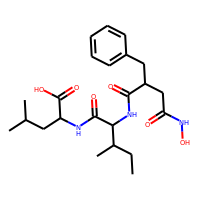
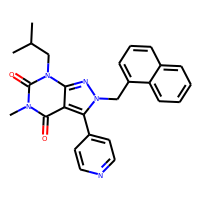
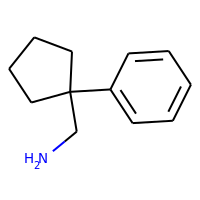
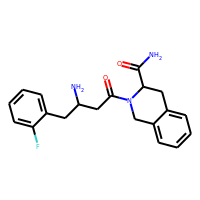
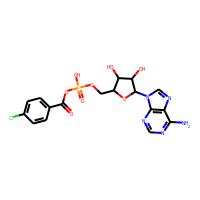

In [5]:
df = prep_df(pd.read_csv('data/200922_pdbID_uniprotID_LigID-Smiles.csv', sep=","))
df.head()

In [4]:
write_smi_file(df, 'data/pdb_ligands.smi')

### Installation of MMPDB
```bash
git clone https://github.com/rdkit/mmpdb.git
cd mmpdb
# Make sure you are in the right conda environment
pip install .
```

### Generate MMPDB (command line)
```bash
mmpdb fragment ../data/pdb_ligands.smi -o pdb_ligands.fragments
mmpdb index pdb_ligands.fragments -o pdb_ligands.mmpdb
```

In [5]:
def load_mmpdb(dbpath, values):
    with sql.connect(dbpath) as con:
        cur = con.cursor()
        pairs = cur.execute('SELECT * FROM pair').fetchall()
        compounds = cur.execute('SELECT id,public_id,clean_smiles FROM compound').fetchall()
        constants = cur.execute('SELECT id,smiles FROM constant_smiles').fetchall()
        rule_envs = cur.execute('SELECT id,rule_id FROM rule_environment').fetchall()
        rules = cur.execute('SELECT * FROM rule').fetchall()
        rule_smiles = cur.execute('SELECT id,smiles FROM rule_smiles').fetchall()
        
    pairs_df = pd.DataFrame(pairs, columns=['id', 'rule_environment_id', 'compound1_lig_id', 'compound2_lig_id', 'constant_id']).set_index('id', verify_integrity=True)
    compounds_df = pd.DataFrame(compounds, columns=['id', 'public_id', 'clean_smiles']).set_index('id', verify_integrity=True)
    constants_df = pd.DataFrame(constants, columns=['id', 'smiles']).set_index('id', verify_integrity=True)
    rule_envs_df = pd.DataFrame(rule_envs, columns=['id', 'rule_id']).set_index('id', verify_integrity=True)
    rules_df = pd.DataFrame(rules, columns=['id', 'from_smiles_id', 'to_smiles_id']).set_index('id', verify_integrity=True)
    rule_smiles_df = pd.DataFrame(rule_smiles, columns=['id', 'smiles']).set_index('id', verify_integrity=True)
    
    data = pairs_df.merge(compounds_df, left_on='compound1_lig_id', right_index=True).drop(columns='compound1_lig_id')
    data = data.merge(compounds_df, left_on='compound2_lig_id', right_index=True).drop(columns='compound2_lig_id')
    data = data.merge(constants_df, left_on='constant_id', right_index=True).drop(columns='constant_id')
    data = data.merge(rule_envs_df, left_on='rule_environment_id', right_index=True).drop(columns='rule_environment_id')
    data = data.merge(rules_df, left_on='rule_id', right_index=True).drop(columns='rule_id')
    data = data.merge(rule_smiles_df, left_on='from_smiles_id', right_index=True).drop(columns='from_smiles_id')
    data = data.merge(rule_smiles_df, left_on='to_smiles_id', right_index=True).drop(columns='to_smiles_id')
    data.columns = ['compound1_lig_id', 'compound1_smi', 'compound2_lig_id', 'compound2_smi', 'constant_smiles', 'from_smiles', 'to_smiles']
    data.drop_duplicates(inplace=True)
    print(f'Unique pairs: {len(data)}')
     
    PandasTools.AddMoleculeColumnToFrame(data, 'compound1_smi', 'compound1')
    PandasTools.AddMoleculeColumnToFrame(data, 'compound2_smi', 'compound2')
    PandasTools.AddMoleculeColumnToFrame(data, 'constant_smiles', 'constant')
    PandasTools.AddMoleculeColumnToFrame(data, 'from_smiles', 'from')
    PandasTools.AddMoleculeColumnToFrame(data, 'to_smiles', 'to')
                                             
    data = data[['compound1_lig_id', 'compound1', 'compound2_lig_id', 'compound2', 'constant', 'from', 'to']]
    
    return data

def group_by_reacts(df):
    trans = []
    for ix, row in df.iterrows():
        trans.append(f'{Chem.MolToSmarts(row["from"])}>>{Chem.MolToSmarts(row["to"])}')
    df = df.copy(deep=False)
    df['reaction_smarts'] = trans
    grouped = df.groupby('reaction_smarts')
    df = grouped.first()
    df['LigID1'] = grouped['compound1_lig_id'].agg(list)
    df['LigID2'] = grouped['compound2_lig_id'].agg(list)
    df = df[['LigID1', 'from','LigID2', 'to']]
    print(f'Unique reactions: {len(df)}')
    return df

Unique pairs: 7607348


compound1_lig_id                                          compound1  \
id                                                                            
0                    0NG  <img data-content="rdkit/molecule" src="data:i...   
108                  BHU  <img data-content="rdkit/molecule" src="data:i...   
114                  BUB  <img data-content="rdkit/molecule" src="data:i...   
6084654              LEA  <img data-content="rdkit/molecule" src="data:i...   
9074160              MK8  <img data-content="rdkit/molecule" src="data:i...   

        compound2_lig_id                                          compound2  \
id                                                                            
0                    4CB  <img data-content="rdkit/molecule" src="data:i...   
108                  4CB  <img data-content="rdkit/molecule" src="data:i...   
114                  4CB  <img data-content="rdkit/molecule" src="data:i...   
6084654              UB7  <img data-content="rdkit/molecule" src="data:i...   
9074160              MCG  <img data-content="rdkit/molecule" src="data:i...   

                                                  constant  \
id                                                           
0        <img data-content="rdkit/molecule" src="data:i...   
108      <img data-content="rdkit/molecule" src="data:i...   
114      <img data-content="rdkit/molecule" src="data:i...   
6084654  <img data-content="rdkit/molecule" src="data:i...   
9074160  <img data-content="rdkit/molecule" src="data:i...   

                                                      from  \
id                                                           
0        <img data-content="rdkit/molecule" src="data:i...   
108      <img data-content="rdkit/molecule" src="data:i...   
114      <img data-content="rdkit/molecule" src="data:i...   
6084654  <img data-content="rdkit/molecule" src="data:i...   
9074160  <img data-content="rdkit/molecule" src="data:i...   

                                                        to  
id                                                          
0        <img data-content="rdkit/molecule" src="data:i...  
108      <img data-content="rdkit/molecule" src="data:i...  
114      <img data-content="rdkit/molecule" src="data:i...  
6084654  <img data-content="rdkit/molecule" src="data:i...  
9074160  <img data-content="rdkit/molecule" src="data:i...
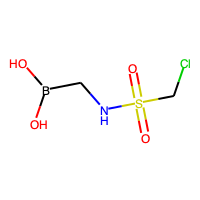
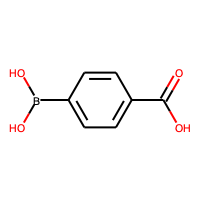
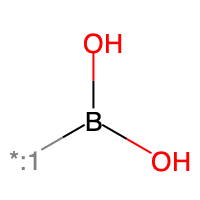
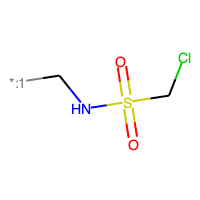
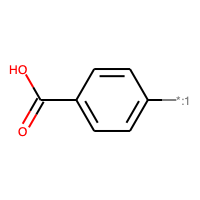
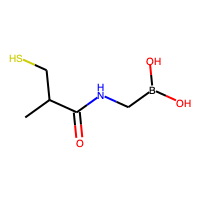
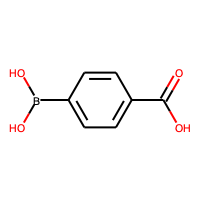
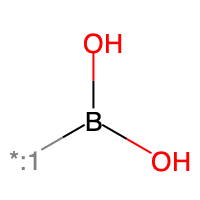
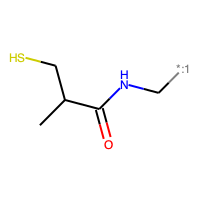
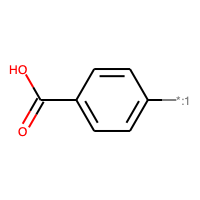
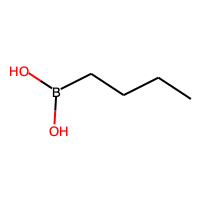
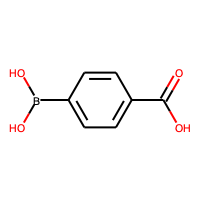
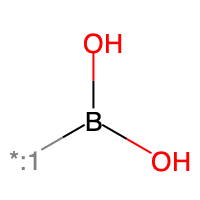
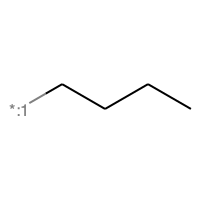
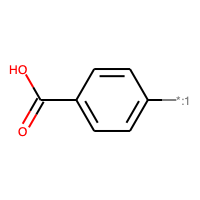
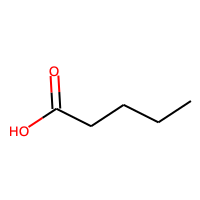
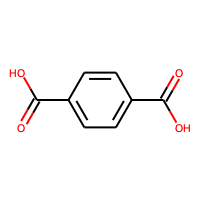
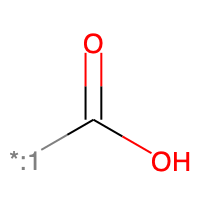
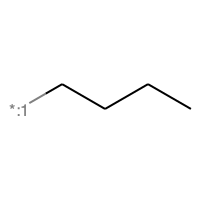
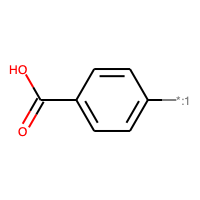
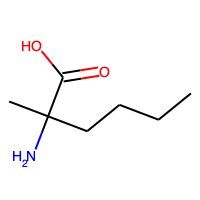
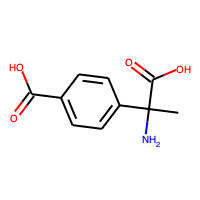
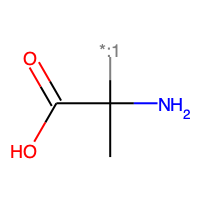
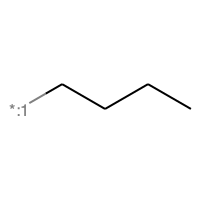
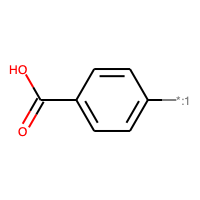

In [6]:
pdb_mmp = load_mmpdb('mmpdb/pdb_ligands.mmpdb', df)
pdb_mmp.head()

### MMP of interest:

[#0:1]-[#9]>>[#0:1]-[H]


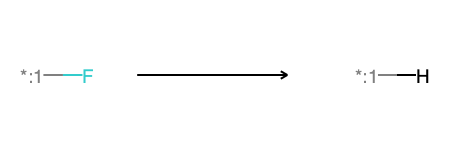

In [7]:
from_mol = Chem.MolFromSmiles('[*:1]F')
to_mol = Chem.MolFromSmiles('[*:1][H]')
react_smarts = f'{Chem.MolToSmarts(from_mol)}>>{Chem.MolToSmarts(to_mol)}'
print(react_smarts)
Chem.ReactionFromSmarts(react_smarts)

Unique reactions: 3633875


LigID1  \
reaction_smarts                                                              
[#0:1]-[#9]>>[#0:1]-[H]  [1Y6, 14O, FP2, 3FA, FPN, 3N8, FBB, URF, CFP, ...   

                                                                      from  \
reaction_smarts                                                              
[#0:1]-[#9]>>[#0:1]-[H]  <img data-content="rdkit/molecule" src="data:i...   

                                                                    LigID2  \
reaction_smarts                                                              
[#0:1]-[#9]>>[#0:1]-[H]  [BEZ, IND, IPH, CAQ, IPH, CAQ, ABV, URA, ES4, ...   

                                                                        to  
reaction_smarts                                                             
[#0:1]-[#9]>>[#0:1]-[H]  <img data-content="rdkit/molecule" src="data:i...
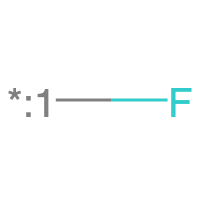
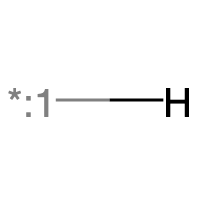

In [8]:
pdb_reacts = group_by_reacts(pdb_mmp)
pdb_reacts.loc[[react_smarts]]

### Iterate over the dataframes to get the final pdbpairs dataframe

LigID1                                               MMP1 LigID2  \
0    1Y6  <img data-content="rdkit/molecule" src="data:i...    BEZ   
1    14O  <img data-content="rdkit/molecule" src="data:i...    IND   
2    FP2  <img data-content="rdkit/molecule" src="data:i...    IPH   
3    3FA  <img data-content="rdkit/molecule" src="data:i...    CAQ   
4    FPN  <img data-content="rdkit/molecule" src="data:i...    IPH   

                                                MMP2  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...
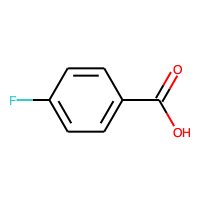
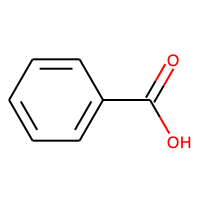
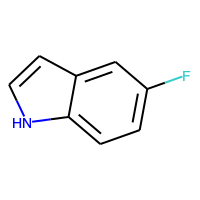
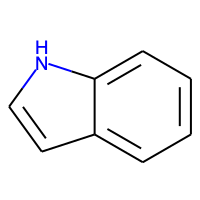
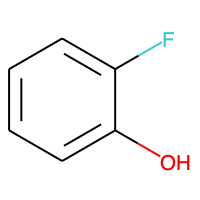
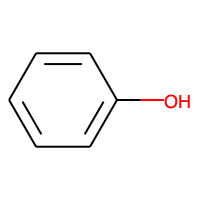
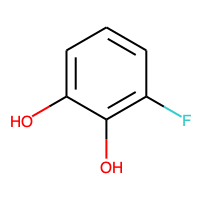
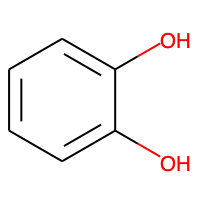
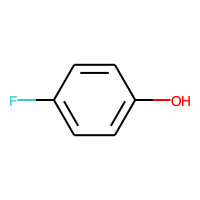
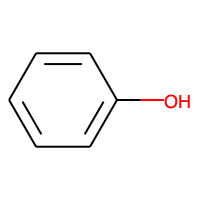

In [9]:
mmp1 = []
for x in pdb_reacts.loc[react_smarts, 'LigID1']:
    mmp1.append(df.ROMol[x])
mmp2 = []
for x in pdb_reacts.loc[react_smarts, 'LigID2']:
    mmp2.append(df.ROMol[x])
subst = pd.DataFrame(
    {
        'LigID1': pdb_reacts.loc[react_smarts, 'LigID1'],
        'MMP1': mmp1,
        'LigID2': pdb_reacts.loc[react_smarts, 'LigID2'],
        'MMP2': mmp2
    }
)
subst.head()

### Assign the corresponding PDB and UniprotID/GeneBankID to the ligands

In [10]:
ent1 = []
ent2 = []
for _, row in subst.iterrows():
    ent1.append(df.loc[row.LigID1]['TotID'])
    ent2.append(df.loc[row.LigID2]['TotID'])
subst['ENT1'] = ent1
subst['ENT2'] = ent2

### Remove the MMP that do not have the same UniProtID/GeneBankID 

In [11]:
uniprot_ids = ddict(list)
for ix, row in subst.iterrows():
    for ent1 in row.ENT1:
        for ent2 in row.ENT2:
            upLigID1 = ent1.split('_')[2]
            if upLigID1 == ent2.split('_')[2]:
                uniprot_ids[ix].append((ent1, ent2))

pdbpairs = subst.loc[uniprot_ids.keys()]

### Display the MMP and remember the row ID for 3D inspection

MMP1  \
0    <img data-content="rdkit/molecule" src="data:i...   
1    <img data-content="rdkit/molecule" src="data:i...   
2    <img data-content="rdkit/molecule" src="data:i...   
3    <img data-content="rdkit/molecule" src="data:i...   
4    <img data-content="rdkit/molecule" src="data:i...   
5    <img data-content="rdkit/molecule" src="data:i...   
6    <img data-content="rdkit/molecule" src="data:i...   
7    <img data-content="rdkit/molecule" src="data:i...   
8    <img data-content="rdkit/molecule" src="data:i...   
9    <img data-content="rdkit/molecule" src="data:i...   
10   <img data-content="rdkit/molecule" src="data:i...   
11   <img data-content="rdkit/molecule" src="data:i...   
12   <img data-content="rdkit/molecule" src="data:i...   
13   <img data-content="rdkit/molecule" src="data:i...   
14   <img data-content="rdkit/molecule" src="data:i...   
15   <img data-content="rdkit/molecule" src="data:i...   
16   <img data-content="rdkit/molecule" src="data:i...   
17   <img data-content="rdkit/molecule" src="data:i...   
18   <img data-content="rdkit/molecule" src="data:i...   
19   <img data-content="rdkit/molecule" src="data:i...   
20   <img data-content="rdkit/molecule" src="data:i...   
21   <img data-content="rdkit/molecule" src="data:i...   
22   <img data-content="rdkit/molecule" src="data:i...   
23   <img data-content="rdkit/molecule" src="data:i...   
24   <img data-content="rdkit/molecule" src="data:i...   
25   <img data-content="rdkit/molecule" src="data:i...   
26   <img data-content="rdkit/molecule" src="data:i...   
27   <img data-content="rdkit/molecule" src="data:i...   
28   <img data-content="rdkit/molecule" src="data:i...   
29   <img data-content="rdkit/molecule" src="data:i...   
30   <img data-content="rdkit/molecule" src="data:i...   
31   <img data-content="rdkit/molecule" src="data:i...   
32   <img data-content="rdkit/molecule" src="data:i...   
33   <img data-content="rdkit/molecule" src="data:i...   
34   <img data-content="rdkit/molecule" src="data:i...   
35   <img data-content="rdkit/molecule" src="data:i...   
36   <img data-content="rdkit/molecule" src="data:i...   
37   <img data-content="rdkit/molecule" src="data:i...   
38   <img data-content="rdkit/molecule" src="data:i...   
39   <img data-content="rdkit/molecule" src="data:i...   
40   <img data-content="rdkit/molecule" src="data:i...   
41   <img data-content="rdkit/molecule" src="data:i...   
42   <img data-content="rdkit/molecule" src="data:i...   
43   <img data-content="rdkit/molecule" src="data:i...   
44   <img data-content="rdkit/molecule" src="data:i...   
45   <img data-content="rdkit/molecule" src="data:i...   
46   <img data-content="rdkit/molecule" src="data:i...   
47   <img data-content="rdkit/molecule" src="data:i...   
48   <img data-content="rdkit/molecule" src="data:i...   
49   <img data-content="rdkit/molecule" src="data:i...   
50   <img data-content="rdkit/molecule" src="data:i...   
51   <img data-content="rdkit/molecule" src="data:i...   
52   <img data-content="rdkit/molecule" src="data:i...   
53   <img data-content="rdkit/molecule" src="data:i...   
54   <img data-content="rdkit/molecule" src="data:i...   
55   <img data-content="rdkit/molecule" src="data:i...   
56   <img data-content="rdkit/molecule" src="data:i...   
57   <img data-content="rdkit/molecule" src="data:i...   
58   <img data-content="rdkit/molecule" src="data:i...   
59   <img data-content="rdkit/molecule" src="data:i...   
60   <img data-content="rdkit/molecule" src="data:i...   
61   <img data-content="rdkit/molecule" src="data:i...   
62   <img data-content="rdkit/molecule" src="data:i...   
63   <img data-content="rdkit/molecule" src="data:i...   
64   <img data-content="rdkit/molecule" src="data:i...   
65   <img data-content="rdkit/molecule" src="data:i...   
66   <img data-content="rdkit/molecule" src="data:i...   
67   <img data-content="rdkit/molecule" src="data:i...   
68   <img data-content="rdkit/molecule" src="dat
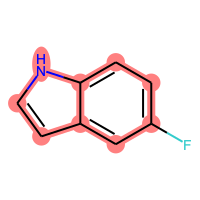
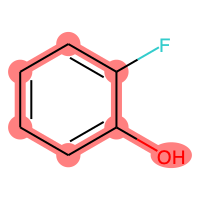
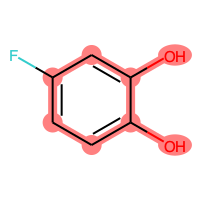
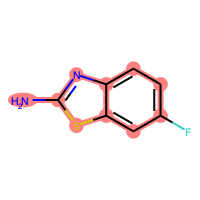
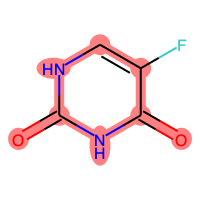
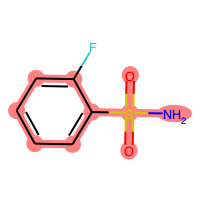
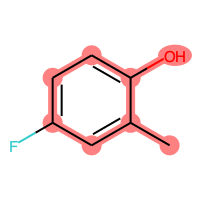
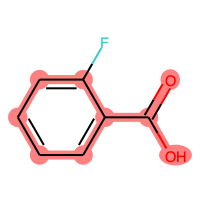
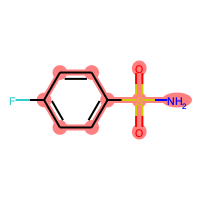
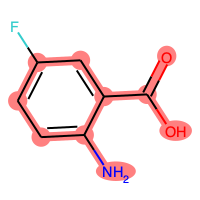
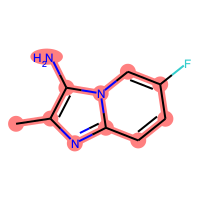
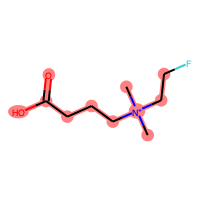
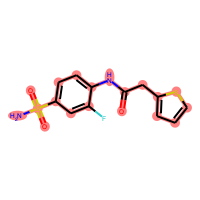
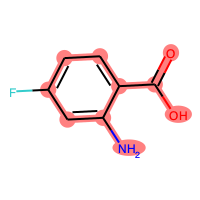
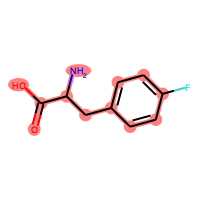
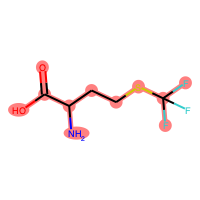
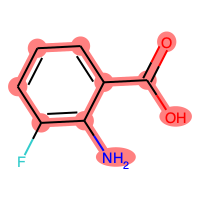
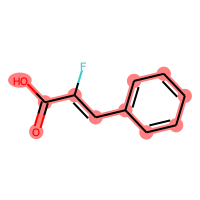
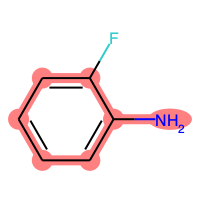
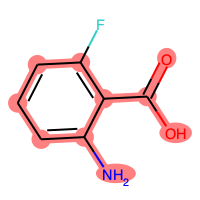
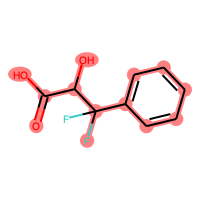
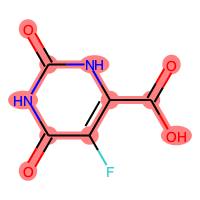
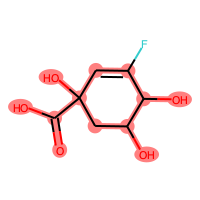
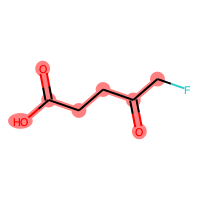
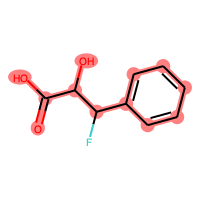
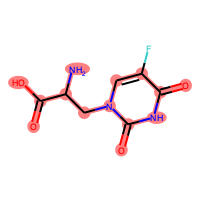
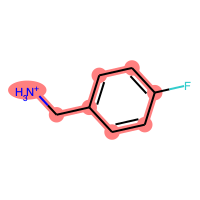
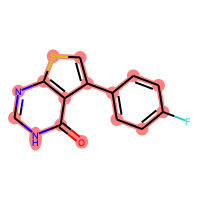
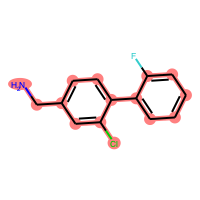
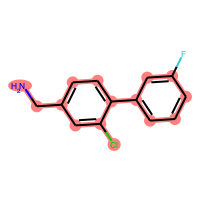
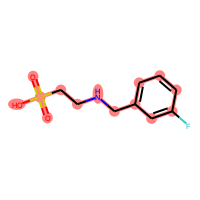
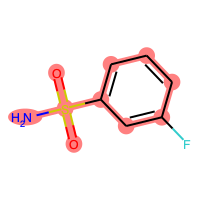
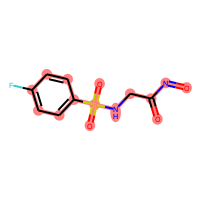
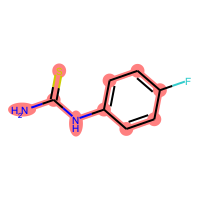
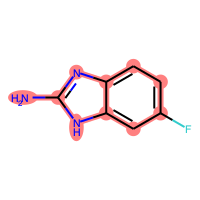
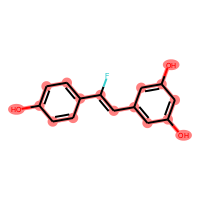
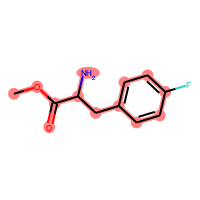
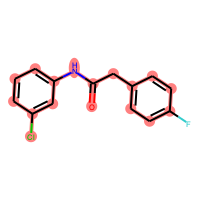
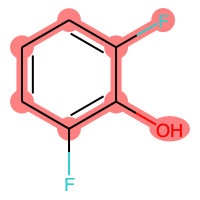
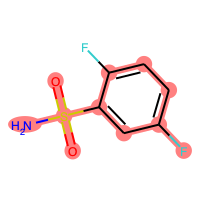
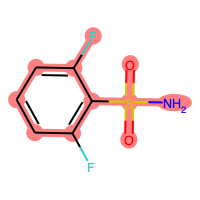
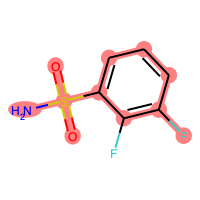
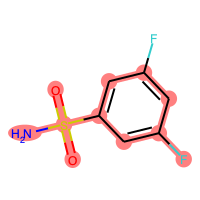
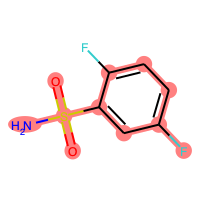
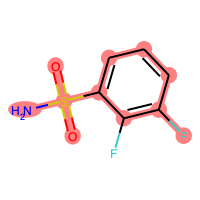
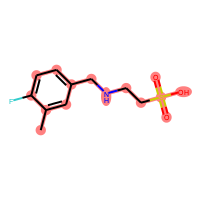
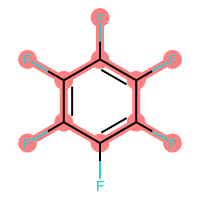
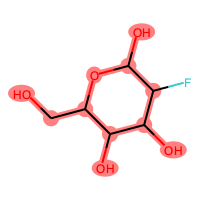
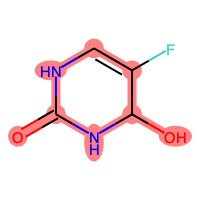
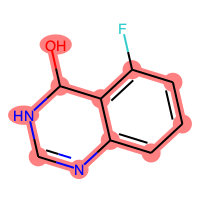
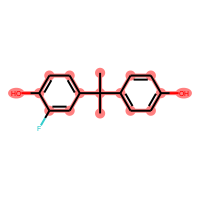
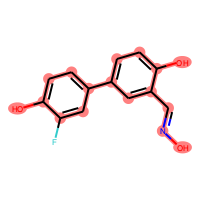
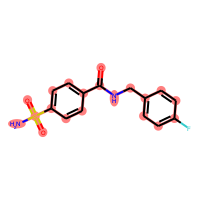
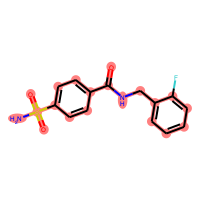
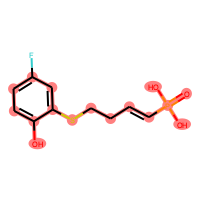
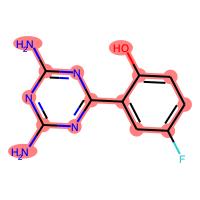
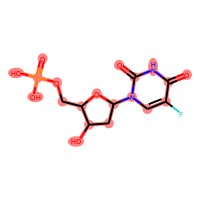
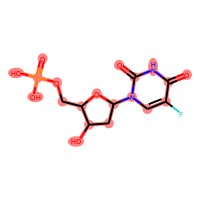
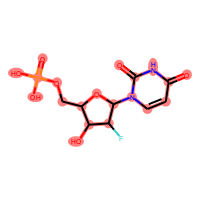
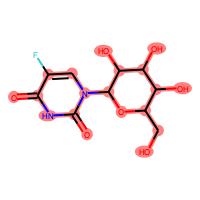
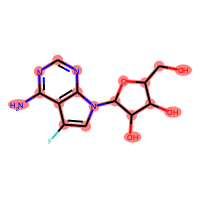
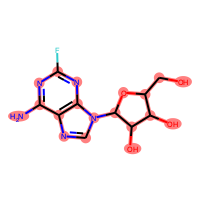
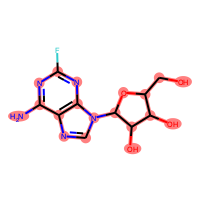
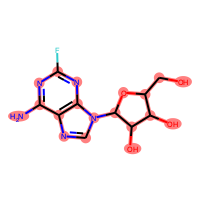
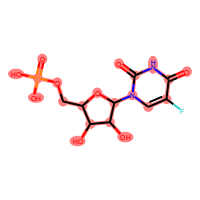
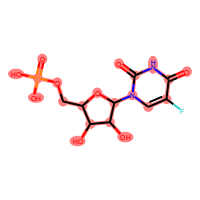
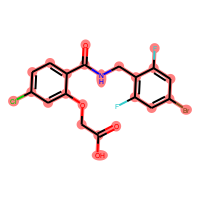
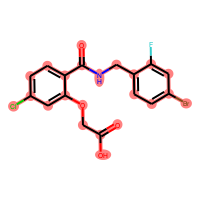
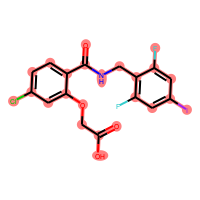
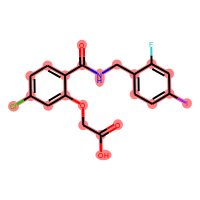
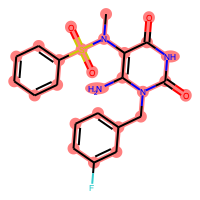
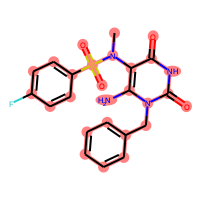
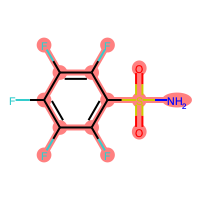
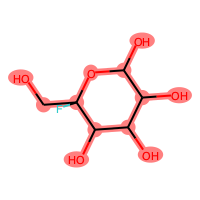
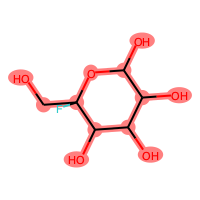
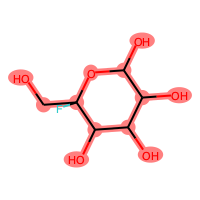
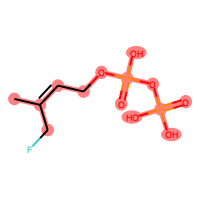
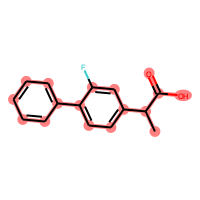
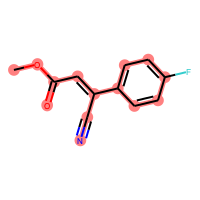
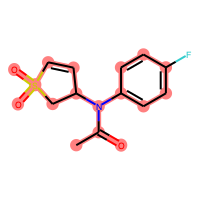
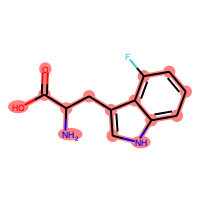
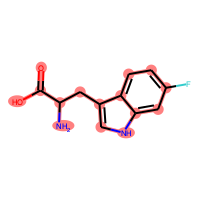
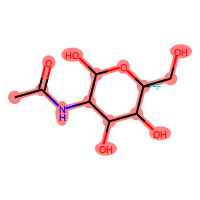
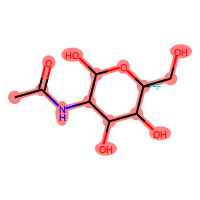
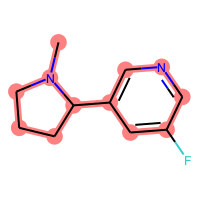
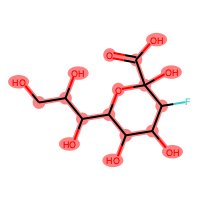
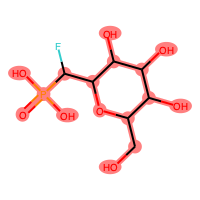
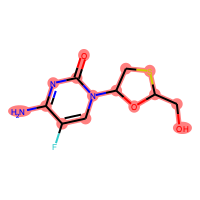
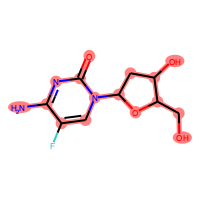
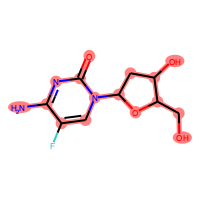
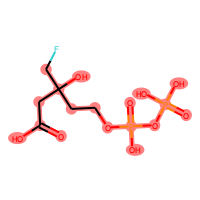
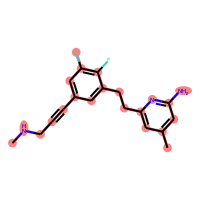
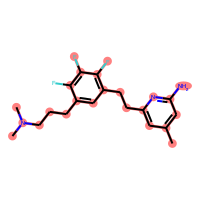
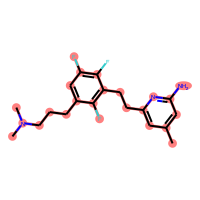
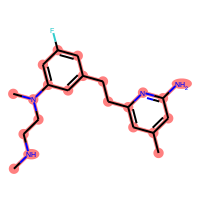
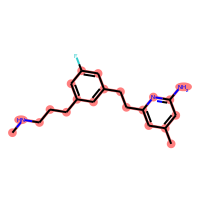
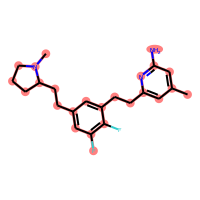
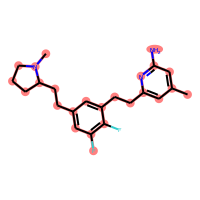
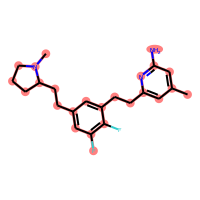
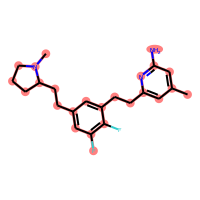
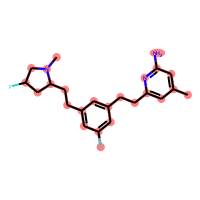
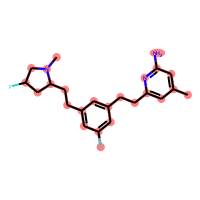
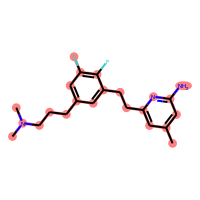
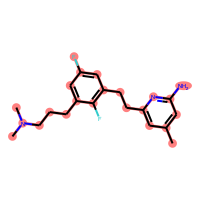
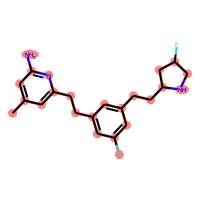
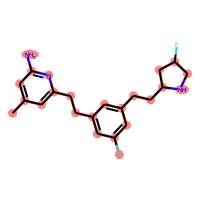
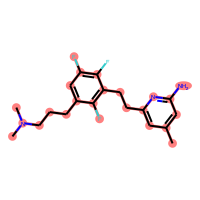
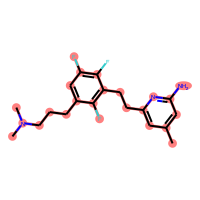
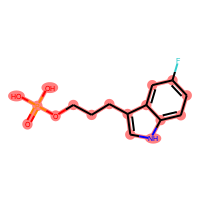
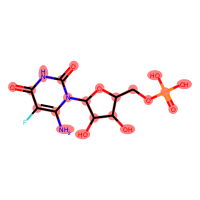
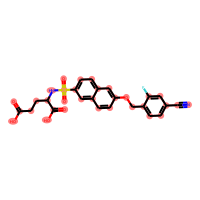
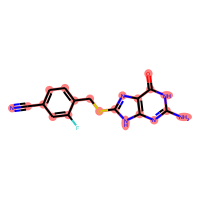
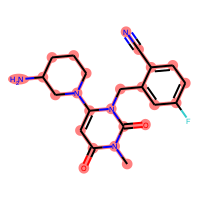
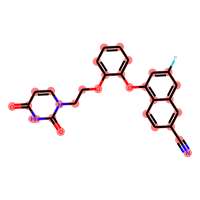
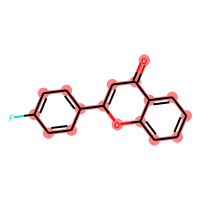
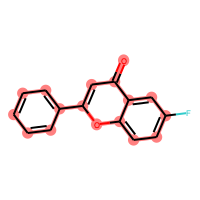
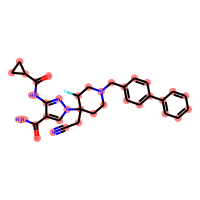
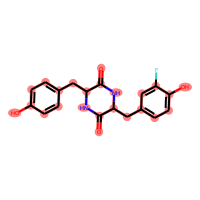
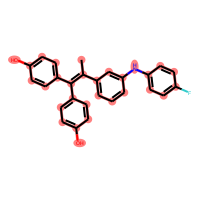
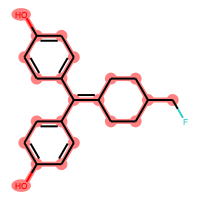
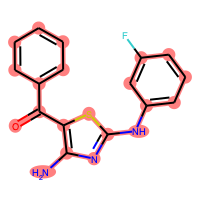
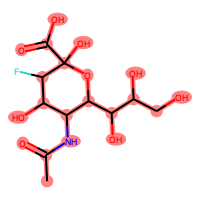
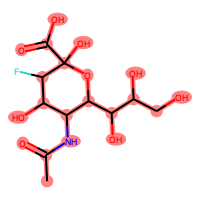
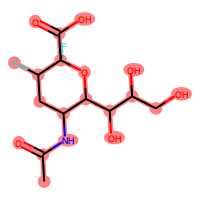
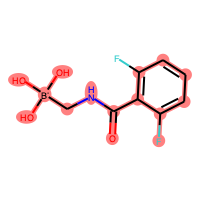
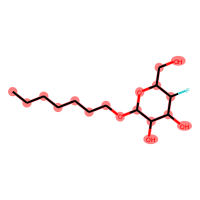
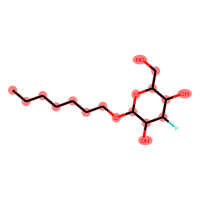
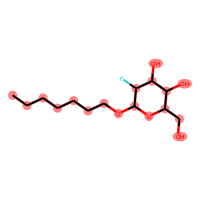
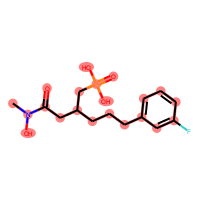
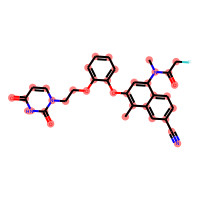
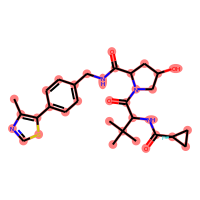
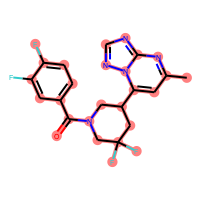
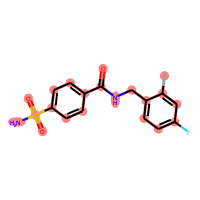
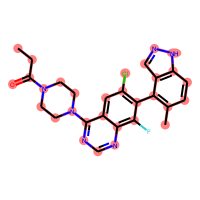
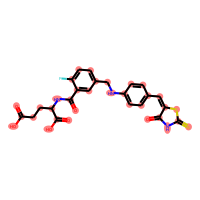
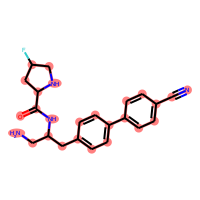
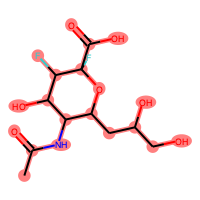
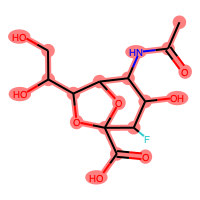
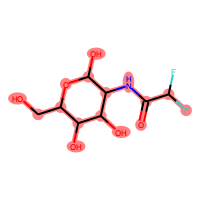
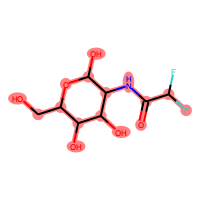
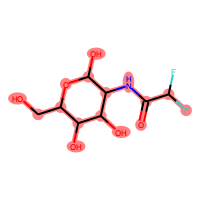
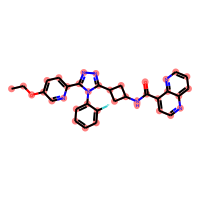
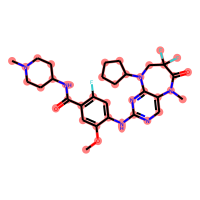
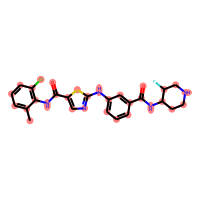
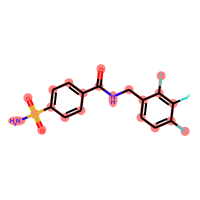
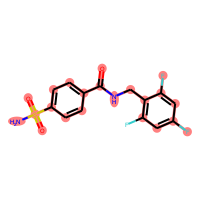
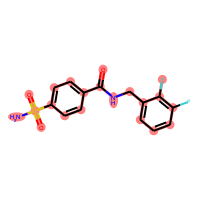
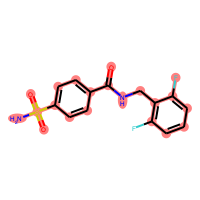
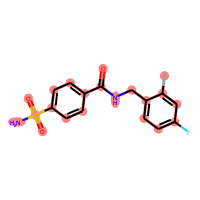
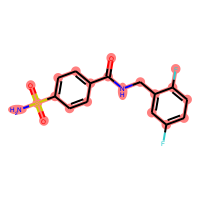
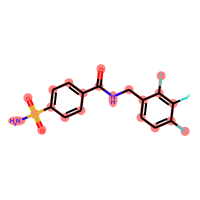
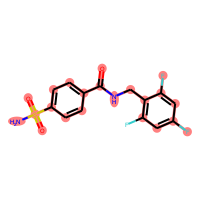
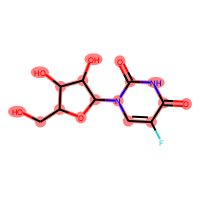
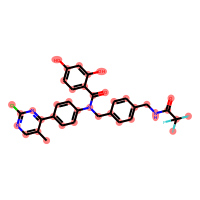
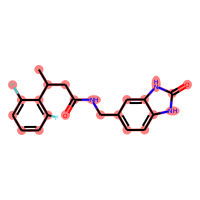
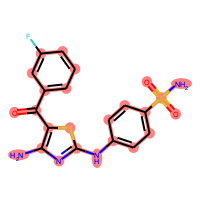
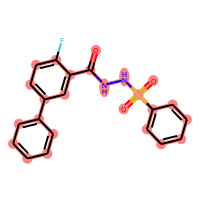
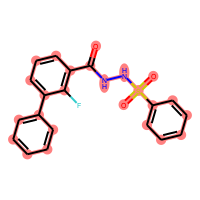
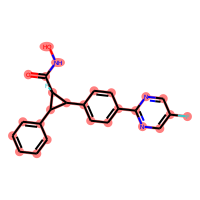
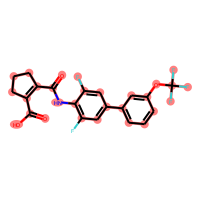
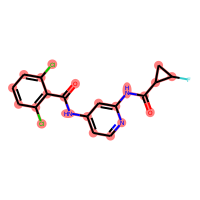
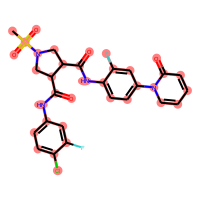
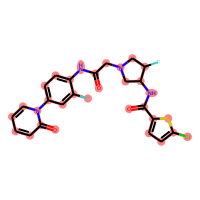
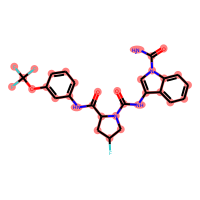
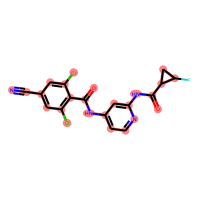
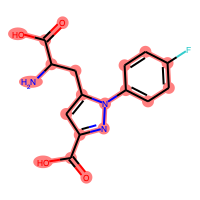
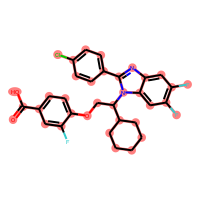
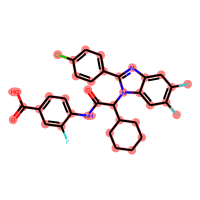
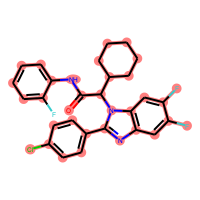
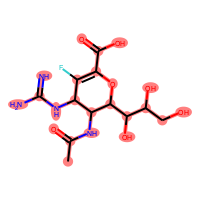
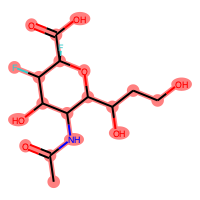
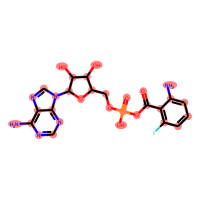
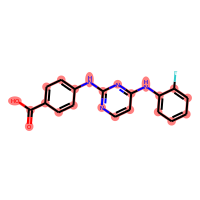
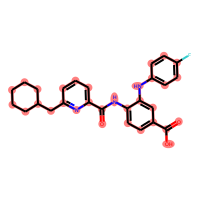
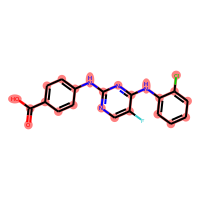
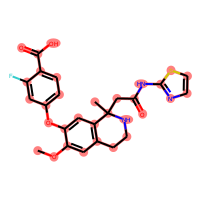
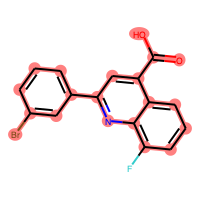
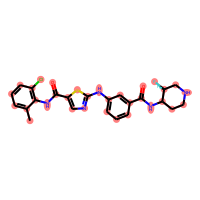
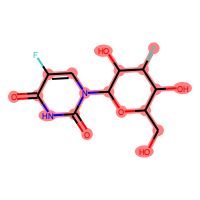
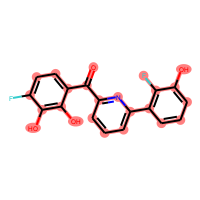
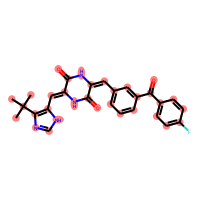
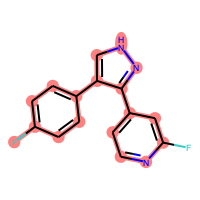
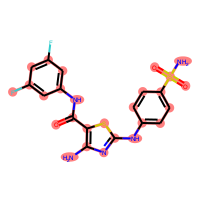
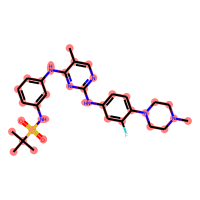
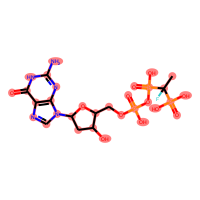
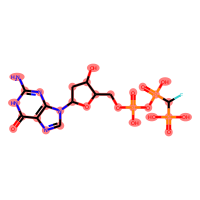
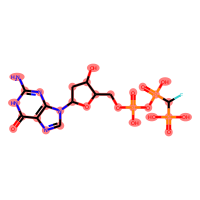
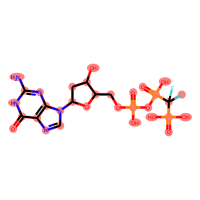
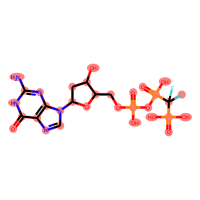
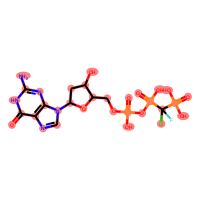
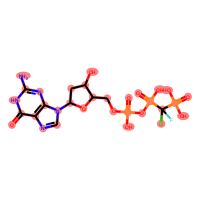
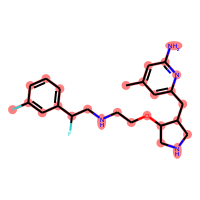
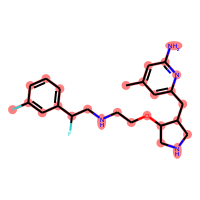
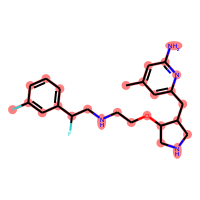
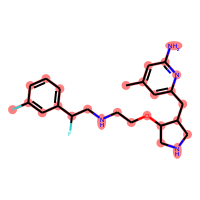
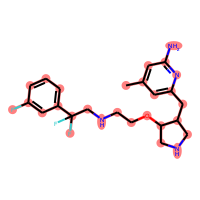
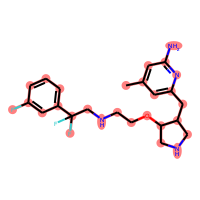
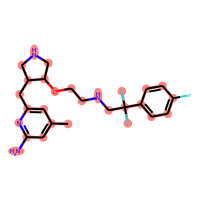
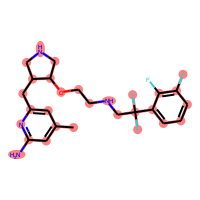
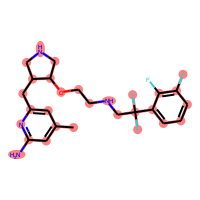
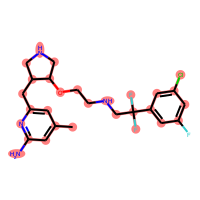
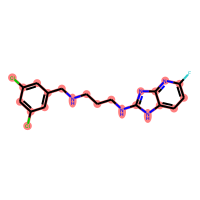
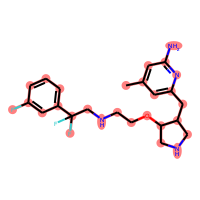
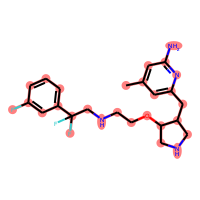
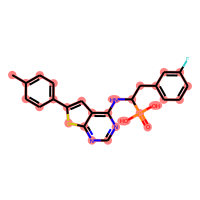
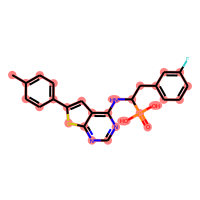
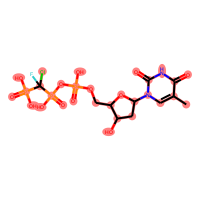
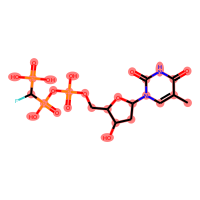
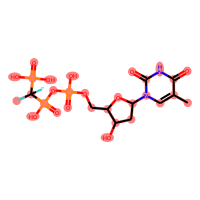
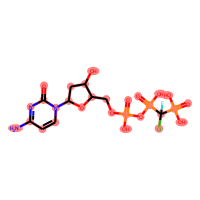
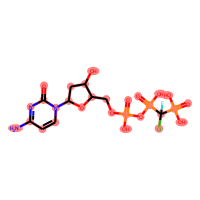
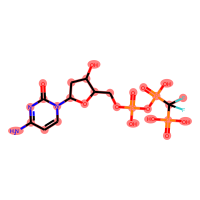
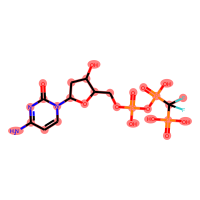
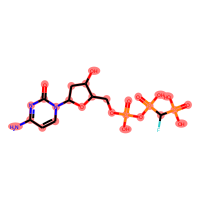
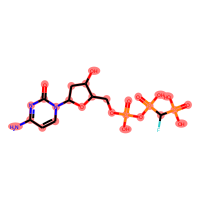
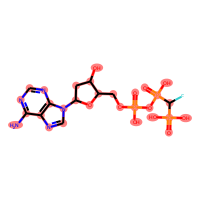
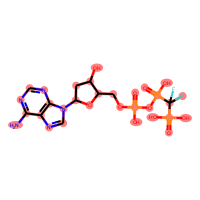
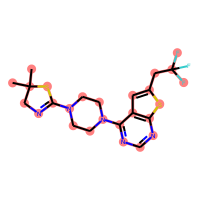
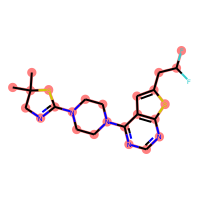
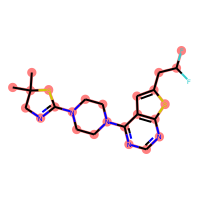
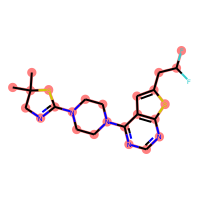
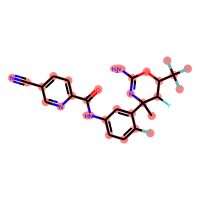
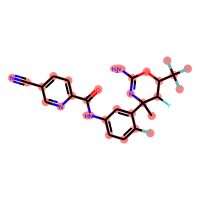
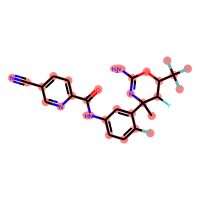
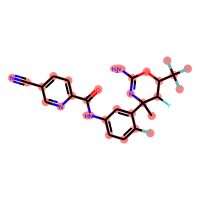
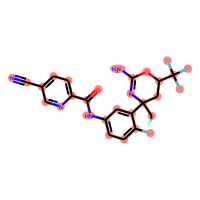
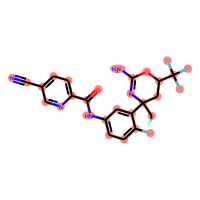
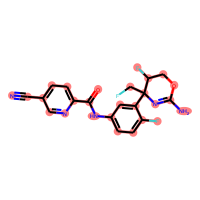
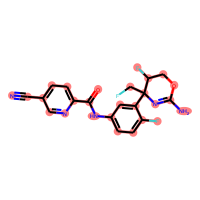
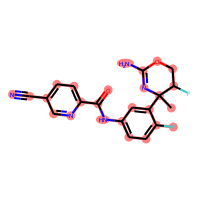
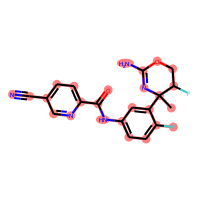
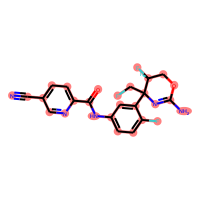
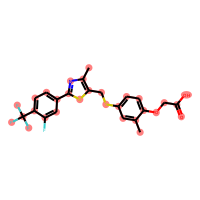
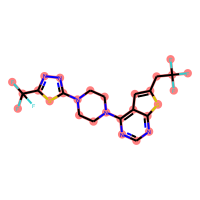
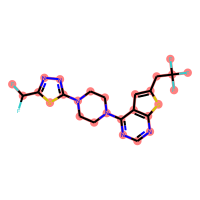
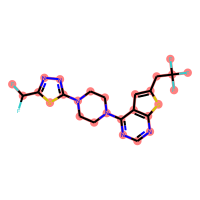
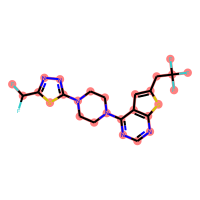
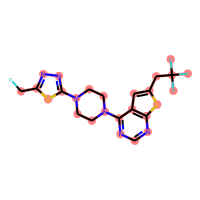
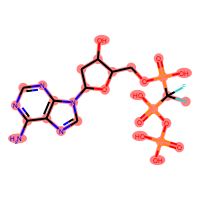
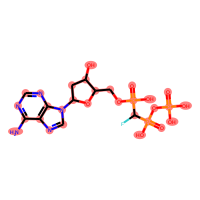
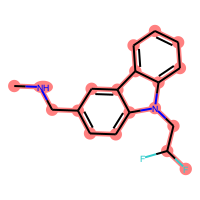
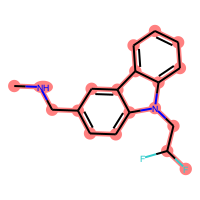
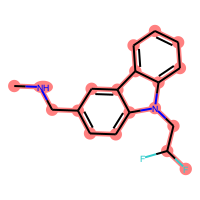
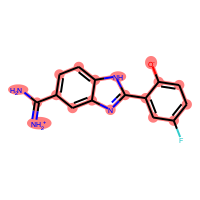
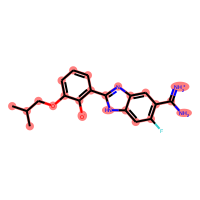
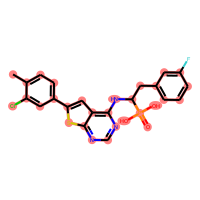
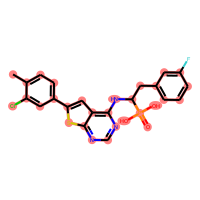
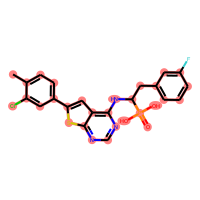
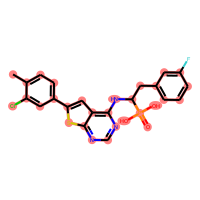
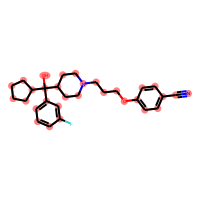
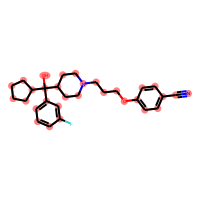
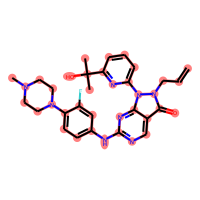
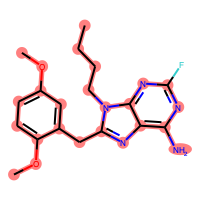
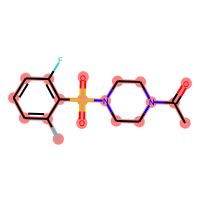
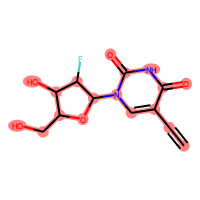
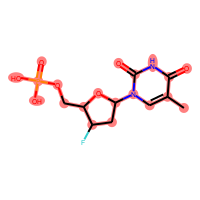
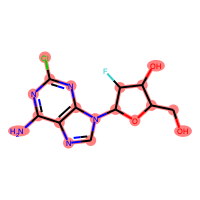
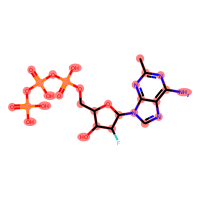
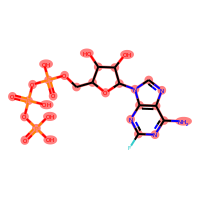
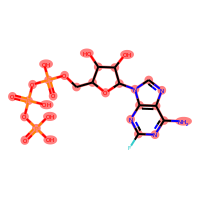
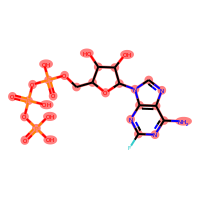
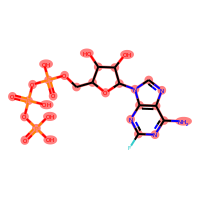
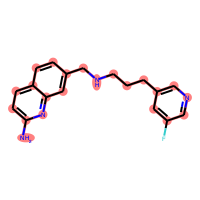
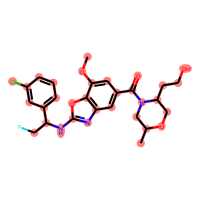
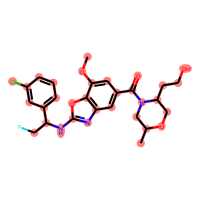
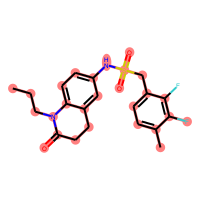
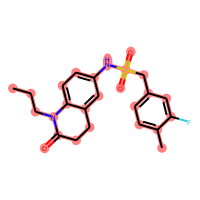
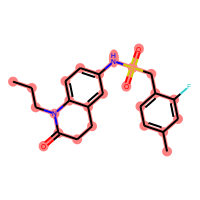
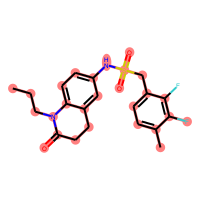
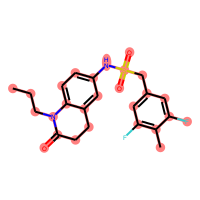
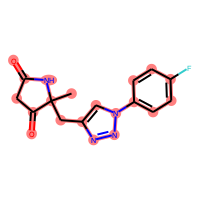
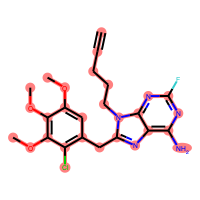
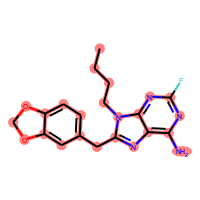
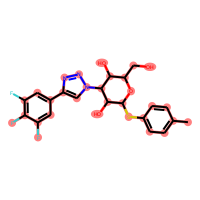
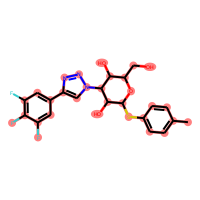
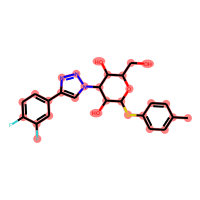
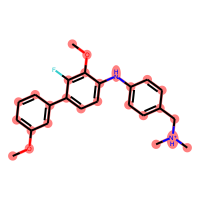
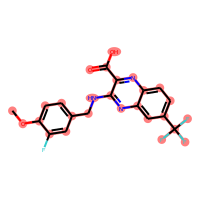
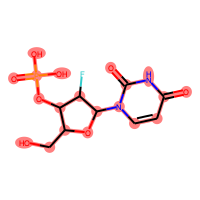
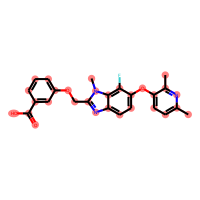
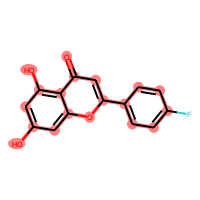
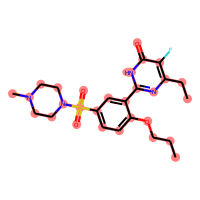
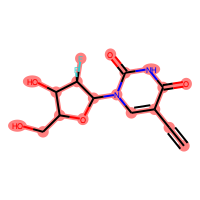
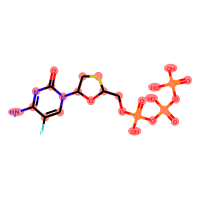
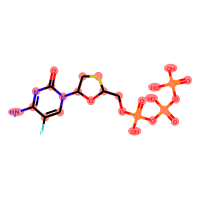
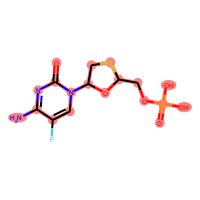
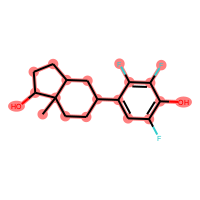
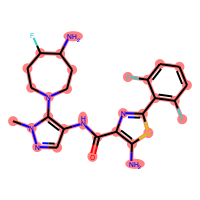
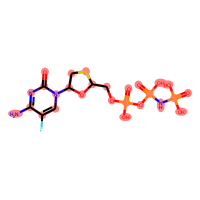
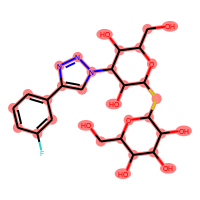
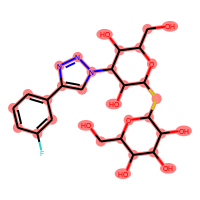
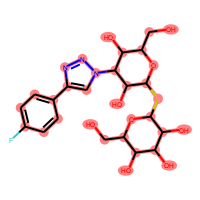
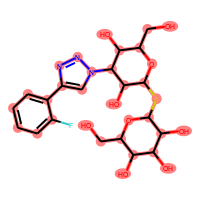
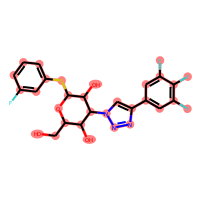
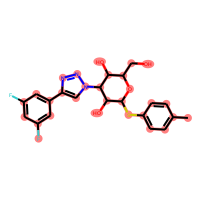
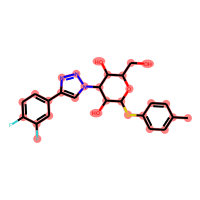
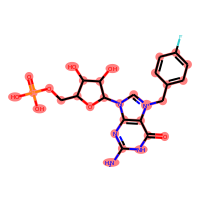
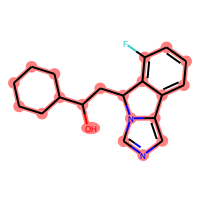
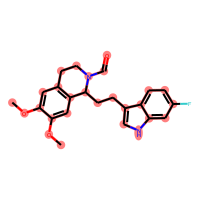
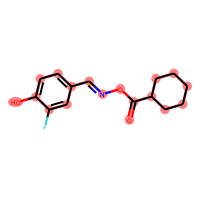
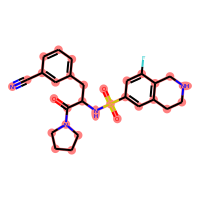
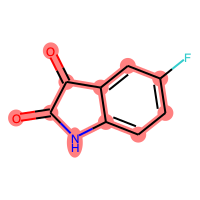
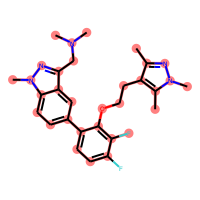
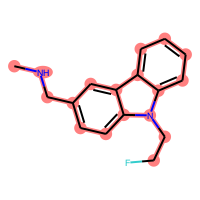
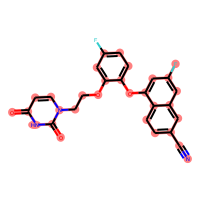
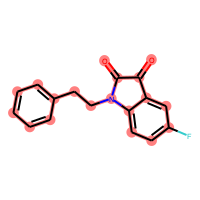
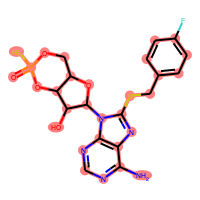
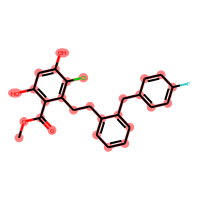
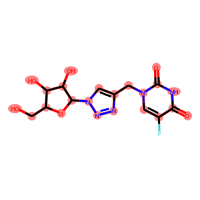
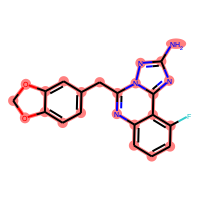
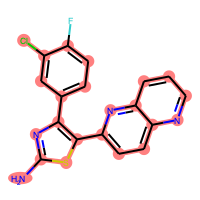
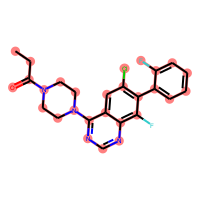
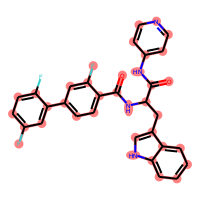
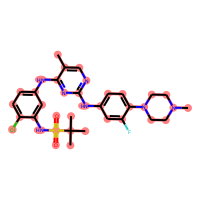
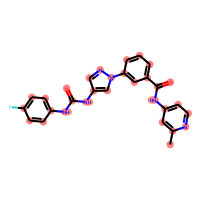
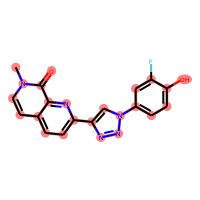
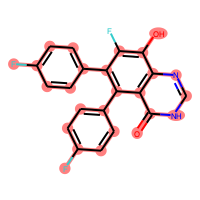
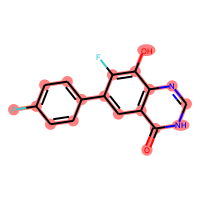
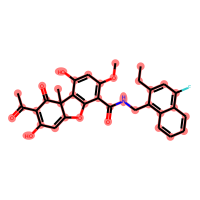
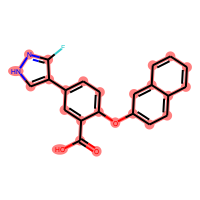
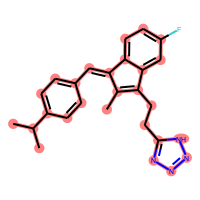
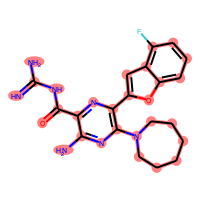

In [12]:
for _, row in pdbpairs.iterrows():
    Chem.Compute2DCoords(row.MMP1)
    Chem.Compute2DCoords(row.MMP2)
    TemplateAlign.AlignMolToTemplate2D(row.MMP1, row.MMP2, clearConfs=True)

pdbpairs['TotID_pairs'] = pdbpairs.index.map(uniprot_ids)
pdbpairs = pdbpairs.reset_index(drop=True)
pdbpairs = pdbpairs[['MMP1', 'TotID_pairs']]
pdbpairs

### Launch pymol RPC Server in terminal/Anaconda prompt on Windows
```bash
pymol -R
```

In [ ]:
srv = xmlrpclib.ServerProxy('http://localhost:9123')

### Use pymol to align the pdb structures

In [14]:
i = int(input('Type in the row number: '))

mmp1_pdb = pdbpairs.TotID_pairs[i][0][0].split("_")[0]
mmp2_pdb = pdbpairs.TotID_pairs[i][0][1].split("_")[0]

srv.do(f'fetch {mmp1_pdb} {mmp2_pdb}, async=0')
srv.do(f'align {mmp1_pdb}, {mmp2_pdb}')
srv.do(f'save {mmp1_pdb}_{mmp2_pdb}.pdb, all')
srv.do('delete all')

Type in the row number: 299


### Show aligned pdb files of MMP in jupyter notebook

In [15]:
view = nglview.show_file(f'{mmp1_pdb}_{mmp2_pdb}.pdb')  # load "3pqr" from RCSB PDB and display viewer widget
print(f'{mmp1_pdb}_{mmp2_pdb}')
view

2OOW_2OOH


NGLWidget()

### Write current view to image file:

In [ ]:
view.download_image(filename=f'{mmp1_pdb}_{mmp2_pdb}.png')